# 数据预处理

In [14]:
import torch
import glob
import os
from collections import OrderedDict, defaultdict
import math
import random
from tqdm import tqdm  # 引入 tqdm 库
import time  # 引入 time 模块
import argparse  # 引入 argparse 模块
import sys
import numpy as np
import torch.optim as optim
import torch.nn as nn
from io import BytesIO
from torch.utils.data import DataLoader, Subset, random_split
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import shutil


In [15]:
# 示例数据样本
sample = {
    'unit1_rgb': '/data2/wzj/Datasets/DeepSense/scenario1/unit1/camera_data/image_BS1_456_00_42_15.jpg',
    'unit1_pwr_60ghz': '/data2/wzj/Datasets/DeepSense/scenario1/unit1/mmWave_data/mmWave_power_0.txt',
    'unit1_loc': '/data2/wzj/Datasets/DeepSense/scenario1/unit1/GPS_data/gps_location.txt',
    'unit1_beam_index': 2
}
sample

{'unit1_rgb': '/data2/wzj/Datasets/DeepSense/scenario1/unit1/camera_data/image_BS1_456_00_42_15.jpg',
 'unit1_pwr_60ghz': '/data2/wzj/Datasets/DeepSense/scenario1/unit1/mmWave_data/mmWave_power_0.txt',
 'unit1_loc': '/data2/wzj/Datasets/DeepSense/scenario1/unit1/GPS_data/gps_location.txt',
 'unit1_beam_index': 2}

## 热力图

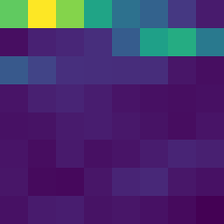

In [ ]:
def mmwave_to_heatmap(mmwave_path, figsize=(3, 3), cmap="viridis", normalize=True):
    # 读取数据
    with open(mmwave_path, 'r') as f:
        lines = f.readlines()
    
    # 确保数据长度为64
    if len(lines) != 64:
        lines = lines[:64] if len(lines) > 64 else lines + ['0'] * (64 - len(lines))
    
    # 解析功率值并转换为8x8矩阵
    powers = np.array([float(line.strip()) for line in lines]).reshape(8, 8)
    
    # 归一化处理
    if normalize:
        min_val, max_val = np.min(powers), np.max(powers)
        if max_val > min_val:
            powers = (powers - min_val) / (max_val - min_val)
    
    # 创建热力图
    plt.figure(figsize=figsize)
    sns.heatmap(
        powers,
        cmap=cmap,
        annot=False,
        cbar=False,
        xticklabels=False,
        yticklabels=False,
        linewidths=0
    )
    plt.axis('off')  # 关闭所有坐标轴
    
    # 保存图像并调整尺寸
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    img = Image.open(buf).convert('RGB')
    img = img.resize((112, 112), Image.Resampling.LANCZOS)
    plt.close()
    
    return img

# 生成并显示热力图
mmwave_img = mmwave_to_heatmap(sample['unit1_pwr_60ghz'])
display(mmwave_img)

## 柱状图

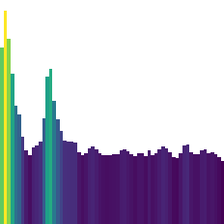

In [21]:
def mmwave_to_barplot(mmwave_path, figsize=(3, 3), cmap="viridis", normalize=True):
    """生成毫米波数据柱状图（无任何文字）"""
    # 读取数据
    with open(mmwave_path, 'r') as f:
        lines = f.readlines()
    
    # 确保数据长度为64
    if len(lines) != 64:
        lines = lines[:64] if len(lines) > 64 else lines + ['0'] * (64 - len(lines))
    
    # 解析功率值
    powers = np.array([float(line.strip()) for line in lines])
    
    # 归一化（用于颜色映射）
    if normalize:
        min_val, max_val = np.min(powers), np.max(powers)
        if max_val > min_val:
            norm_powers = (powers - min_val) / (max_val - min_val)
        else:
            norm_powers = np.zeros_like(powers)
    else:
        norm_powers = powers
    
    # 创建颜色映射（使用新的Matplotlib API）
    cmap = plt.colormaps.get_cmap(cmap)  # 修复弃用警告
    colors = cmap(norm_powers)
    
    # 创建柱状图
    plt.figure(figsize=figsize)
    plt.bar(
        x=np.arange(64),
        height=powers,
        color=colors,
        width=1.0,
        align='center'
    )
    plt.xlim(-0.5, 63.5)  # 设置x轴范围，确保柱状图填充整个可视区域，消除左右空白
    # 完全去除边框和坐标轴
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    
    # 保存图像并调整尺寸
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    img = Image.open(buf).convert('RGB')
    img = img.resize((224, 224), Image.Resampling.LANCZOS)
    plt.close()
    
    return img
mmwave_img = mmwave_to_barplot(sample['unit1_pwr_60ghz'])
display(mmwave_img)

In [22]:
def process_all_scenarios(input_base_dir, output_base_dir, scenarios=range(1, 10), file_ext='.txt', **kwargs):
    """
    处理所有场景的毫米波数据（修正版：仅处理unit1/mmWave_data目录）
    
    Args:
        input_base_dir (str): 输入数据根目录
        output_base_dir (str): 输出数据根目录
        scenarios (iterable): 要处理的情景编号（默认1-9）
        file_ext (str): 目标文件扩展名
        **kwargs: 传递给mmwave_to_heatmap的参数
    """
    for scenario_num in scenarios:
        # 构建具体输入路径（关键修改点1：直接定位到目标子目录）
        scenario_input = os.path.join(
            input_base_dir, 
            f"scenario{scenario_num}",
            "unit1",  # 固定unit1层级
            "mmWave_data"  # 固定数据目录
        )
        
        # 构建对应输出路径（保持相同子目录结构）
        scenario_output = os.path.join(
            output_base_dir,
            f"scenario{scenario_num}",
            "unit1",
            "mmWave_heatmap"
        )
        
        # 确保输入目录存在
        if not os.path.exists(scenario_input):
            print(f"警告：输入目录不存在 {scenario_input}")
            continue
            
        # 创建输出目录
        os.makedirs(scenario_output, exist_ok=True)
        
        # 获取目标文件列表（关键修改点3：直接处理该目录下的文件）
        try:
            files = [f for f in os.listdir(scenario_input) if f.endswith(file_ext)]
        except Exception as e:
            print(f"无法读取目录 {scenario_input}: {str(e)}")
            continue
            
        # 添加进度条（新增功能）
        with tqdm(total=len(files), desc=f"场景 {scenario_num}") as pbar:
            for filename in files:
                input_path = os.path.join(scenario_input, filename)
                output_path = os.path.join(scenario_output, f"{os.path.splitext(filename)[0]}.png")
                
                try:
                    img = mmwave_to_heatmap(input_path, **kwargs)
                    img.save(output_path)
                except Exception as e:
                    print(f"\n处理失败：{input_path} -> {str(e)}")
                finally:
                    pbar.update(1)  # 更新进度条


## 批量生成热力图


In [23]:
# 输入数据根目录（根据实际路径修改）
input_root = "/data2/wzj/Datasets/DeepSense"
# 输出数据根目录（根据实际路径修改）
output_root = "/data2/wzj/Datasets/DeepSense"

process_all_scenarios(
    input_base_dir=input_root,
    output_base_dir=output_root,
    scenarios=range(1, 10),  # 处理scenario1-9
    file_ext=".txt",
    figsize=(3, 3),
    cmap="viridis",
    normalize=True
)

场景 9: 100%|██████████| 5964/5964 [02:19<00:00, 42.82it/s] 


## 将生成的热力图添加到scenario.csv文件中

In [39]:

def add_heatmap_column_only(csv_path, backup=True):
    """ 更新列内容（无论列是否存在） """
    try:
        csv_path = Path(csv_path)
        df = pd.read_csv(csv_path)
        original_shape = df.shape
        
        # 路径生成逻辑
        def get_heatmap_path(pwr_path):
            try:
                p = Path(pwr_path)
                return "./" + str(
                    p.parent.parent / "mmWave_heatmap" / p.with_suffix(".png").name
                )
            except:
                return ""
        
        # 强制更新列内容
        df["unit1_mmwave_heatmap"] = df["unit1_pwr_60ghz"].apply(get_heatmap_path)
        
        # 安全验证
        if df.shape != original_shape:
            raise ValueError(f"数据维度从 {original_shape} 变为 {df.shape}")
            
        # 条件备份
        backup_path = csv_path.with_name(csv_path.stem + "_backup.csv")
        if backup and not backup_path.exists():
            shutil.copy(csv_path, backup_path)
        
        df.to_csv(csv_path, index=False)
        return True
    except Exception as e:
        print(f"处理失败：{csv_path} -> {str(e)}")
        return False

def batch_process_scenarios():
    """ 批量处理场景1-9 """
    base_dir = "/data2/wzj/Datasets/DeepSense"
    
    for i in range(1, 10):
        csv_path = Path(base_dir) / f"scenario{i}" / f"scenario{i}.csv"
        if csv_path.exists():
            print(f"处理场景 {i}")
            add_heatmap_column_only(csv_path)
        else:
            print(f"跳过不存在的文件：{csv_path}")

In [40]:
batch_process_scenarios()

处理场景 1
处理场景 2
处理场景 3
处理场景 4
处理场景 5
处理场景 6
处理场景 7
处理场景 8
处理场景 9


## 加载数据查看效果

In [41]:
from datasets import load_dataset, concatenate_datasets

# 手动指定场景 1-8 的路径
scenario_paths = [f'/data2/wzj/Datasets/DeepSense/scenario{i}/scenario{i}.csv' for i in range(1, 9)]

# 分别加载每个场景的数据集
datasets_list = []
for path in scenario_paths:
    try:
        subset = load_dataset('csv', data_files=path, split='train')
        print(f"成功加载 {path}: {len(subset)} 个样本")
        datasets_list.append(subset)
    except Exception as e:
        print(f"加载失败: {path} - 错误: {e}")

# 合并所有有效数据集
if datasets_list:
    dataset = concatenate_datasets(datasets_list)
    print(f"合并后的总样本数: {len(dataset)}")
else:
    print("未找到任何有效 CSV 文件！")

print(dataset)  # 查看数据集的基本信息
print(dataset.num_rows)  # 查看行数
print(dataset.column_names)  # 查看列名


Generating train split: 0 examples [00:00, ? examples/s]

成功加载 /data2/wzj/Datasets/DeepSense/scenario1/scenario1.csv: 2411 个样本


Generating train split: 0 examples [00:00, ? examples/s]

成功加载 /data2/wzj/Datasets/DeepSense/scenario2/scenario2.csv: 2974 个样本


Generating train split: 0 examples [00:00, ? examples/s]

成功加载 /data2/wzj/Datasets/DeepSense/scenario3/scenario3.csv: 1487 个样本


Generating train split: 0 examples [00:00, ? examples/s]

成功加载 /data2/wzj/Datasets/DeepSense/scenario4/scenario4.csv: 1867 个样本


Generating train split: 0 examples [00:00, ? examples/s]

成功加载 /data2/wzj/Datasets/DeepSense/scenario5/scenario5.csv: 2300 个样本


Generating train split: 0 examples [00:00, ? examples/s]

成功加载 /data2/wzj/Datasets/DeepSense/scenario6/scenario6.csv: 915 个样本


Generating train split: 0 examples [00:00, ? examples/s]

成功加载 /data2/wzj/Datasets/DeepSense/scenario7/scenario7.csv: 854 个样本


Generating train split: 0 examples [00:00, ? examples/s]

成功加载 /data2/wzj/Datasets/DeepSense/scenario8/scenario8.csv: 4043 个样本
合并后的总样本数: 16851
Dataset({
    features: ['index', 'unit1_rgb', 'unit1_pwr_60ghz', 'unit1_loc', 'unit2_loc', 'Unnamed: 5', 'unit1_beam_index', 'seq_index', 'time_stamp[UTC]', 'unit2_direction', 'unit2_num_sat', 'unit2_sat_used', 'unit2_fix_type', 'unit2_DGPS', 'unit2_PDOP', 'unit2_HDOP', 'unit1_mmwave_heatmap', 'unit1_lidar', 'unit1_lidar_SCR', 'unit2_loc_cal', 'Unnamed: 8'],
    num_rows: 16851
})
16851
['index', 'unit1_rgb', 'unit1_pwr_60ghz', 'unit1_loc', 'unit2_loc', 'Unnamed: 5', 'unit1_beam_index', 'seq_index', 'time_stamp[UTC]', 'unit2_direction', 'unit2_num_sat', 'unit2_sat_used', 'unit2_fix_type', 'unit2_DGPS', 'unit2_PDOP', 'unit2_HDOP', 'unit1_mmwave_heatmap', 'unit1_lidar', 'unit1_lidar_SCR', 'unit2_loc_cal', 'Unnamed: 8']


In [42]:
print(dataset['unit1_mmwave_heatmap'][:1])

['./unit1/mmWave_heatmap/mmWave_power_0.png']
